# Exploratory Data Analysis

**Objectives:**
- Understand the distribution of features and target variable
- Identify relationships between features and churn
- Detect potential multicollinearity issues
- Generate actionable insights for modeling decisions

This notebook focuses on **analysis and interpretation only** —
no data transformations are applied here.

## 1. Setup and Data Loading

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

In [35]:
# Load prepared data
df = pd.read_csv("../data/processed/telco_churn_prepared.csv")

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [36]:
# Define feature groups for analysis
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]

categorical_features = [
    "gender", "SeniorCitizen", "Partner", "Dependents",
    "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]

target = "Churn"

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

Numerical features: 3
Categorical features: 16


---
## 2. Target Variable Analysis

In [37]:
# Target distribution
churn_counts = df[target].value_counts()
churn_pct = df[target].value_counts(normalize=True) * 100

print("Churn Distribution:")
print(f"  No:  {churn_counts['No']:,} ({churn_pct['No']:.1f}%)")
print(f"  Yes: {churn_counts['Yes']:,} ({churn_pct['Yes']:.1f}%)")
print(f"\nChurn Rate: {churn_pct['Yes']:.1f}%")

Churn Distribution:
  No:  5,174 (73.5%)
  Yes: 1,869 (26.5%)

Churn Rate: 26.5%


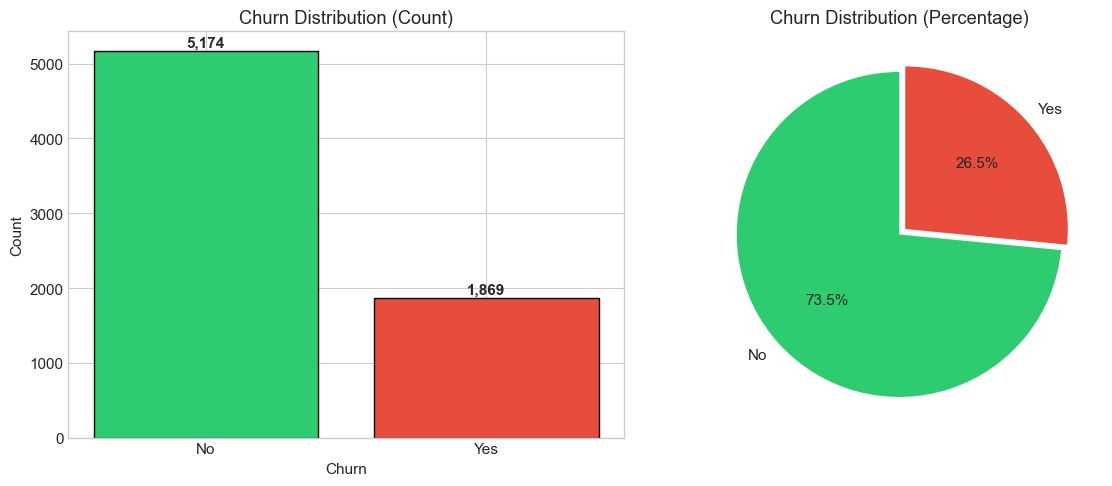

In [38]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
colors = ["#2ecc71", "#e74c3c"]
axes[0].bar(churn_counts.index, churn_counts.values, color=colors, edgecolor="black")
axes[0].set_xlabel("Churn")
axes[0].set_ylabel("Count")
axes[0].set_title("Churn Distribution (Count)")
for i, (idx, val) in enumerate(churn_counts.items()):
    axes[0].text(i, val + 50, f"{val:,}", ha="center", fontweight="bold")

# Pie chart
axes[1].pie(churn_counts.values, labels=churn_counts.index, autopct="%1.1f%%",
            colors=colors, explode=(0, 0.05), startangle=90)
axes[1].set_title("Churn Distribution (Percentage)")

plt.tight_layout()
plt.show()

### Target Analysis — Interpretation

- **Churn rate: ~26.5%** — moderately imbalanced dataset
- Not severe enough to require resampling techniques (SMOTE, etc.)
- However, **accuracy is not an appropriate metric** — a naive model predicting "No" would achieve 73.5% accuracy

**Modeling implications:**
- Use **Recall** as primary metric (cost of missing a churner is high)
- Use **ROC-AUC** for ranking quality
- Consider `class_weight='balanced'` in models

---
## 3. Numerical Features Analysis

In [39]:
# Descriptive statistics for numerical features
df[numerical_features].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.00,7043.00,7032.00
mean,32.37,64.76,2283.30
std,24.56,30.09,2266.77
min,0.00,18.25,18.80
25%,9.00,35.50,401.45
50%,29.00,70.35,1397.47
75%,55.00,89.85,3794.74
max,72.00,118.75,8684.80


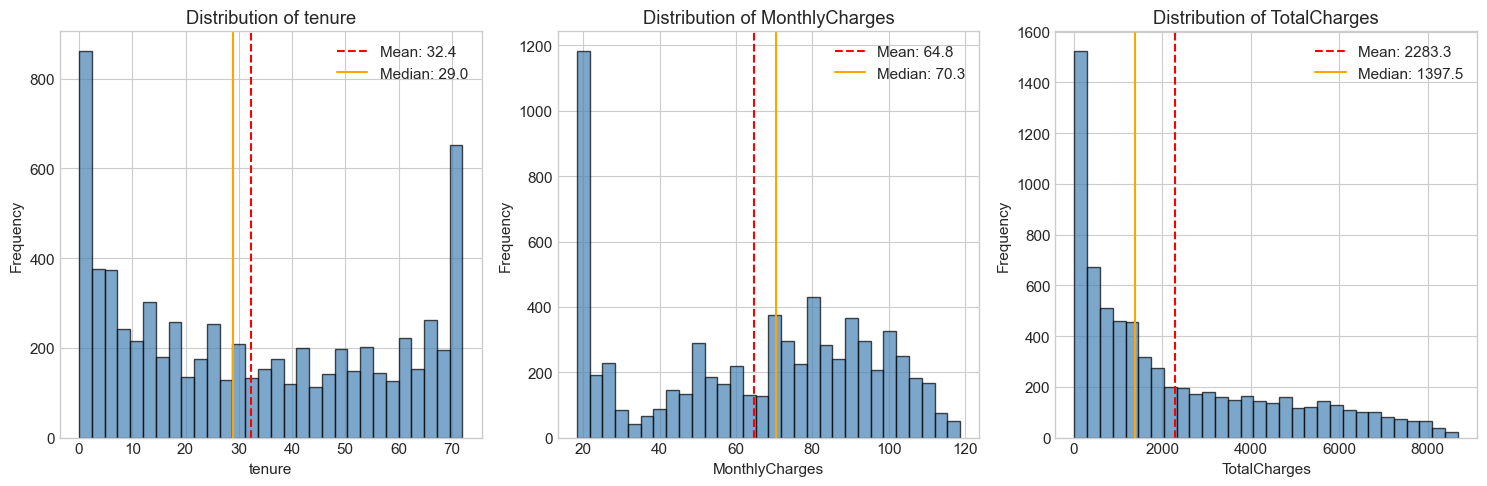

In [40]:
# Distribution of numerical features
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(numerical_features):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor="black", alpha=0.7, color="steelblue")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].axvline(df[col].mean(), color="red", linestyle="--", label=f"Mean: {df[col].mean():.1f}")
    axes[i].axvline(df[col].median(), color="orange", linestyle="-", label=f"Median: {df[col].median():.1f}")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [41]:
# Outlier detection using IQR method
print("Outlier Detection (IQR Method):")
print("=" * 50)

for col in numerical_features:
    data = df[col].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((data < lower) | (data > upper)).sum()
    print(f"{col}:")
    print(f"  Range: [{lower:.2f}, {upper:.2f}]")
    print(f"  Outliers: {outliers} ({outliers/len(data)*100:.2f}%)")

Outlier Detection (IQR Method):
tenure:
  Range: [-60.00, 124.00]
  Outliers: 0 (0.00%)
MonthlyCharges:
  Range: [-46.02, 171.38]
  Outliers: 0 (0.00%)
TotalCharges:
  Range: [-4688.48, 8884.67]
  Outliers: 0 (0.00%)


### 3.1 Numerical Features vs Churn

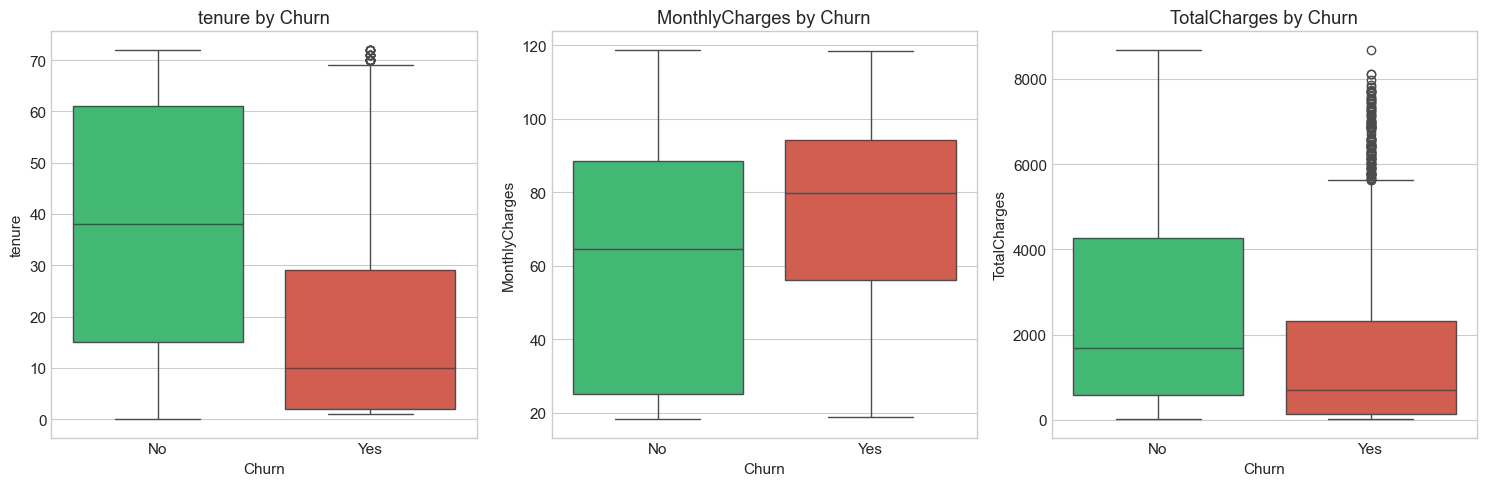

In [42]:
# Boxplots: Numerical features by Churn
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(numerical_features):
    sns.boxplot(
        x=target,
        y=col,
        hue=target,             
        data=df,
        ax=axes[i],
        palette={
            "No": "#2ecc71",
            "Yes": "#e74c3c"
        },
        legend=False             
    )
    axes[i].set_title(f"{col} by Churn")

plt.tight_layout()
plt.show()

In [43]:
# Statistical comparison: mean values by churn status
print("Mean Values by Churn Status:")
print("=" * 50)
comparison = df.groupby(target)[numerical_features].mean().T
comparison["Difference"] = comparison["Yes"] - comparison["No"]
comparison["% Difference"] = (comparison["Difference"] / comparison["No"] * 100).round(1)
comparison

Mean Values by Churn Status:


Churn,No,Yes,Difference,% Difference
tenure,37.57,17.98,-19.59,-52.10
MonthlyCharges,61.27,74.44,13.18,21.50
TotalCharges,2555.34,1531.80,-1023.55,-40.10


In [44]:
# Statistical significance tests (t-test)
print("\nStatistical Significance Tests (Independent t-test):")
print("=" * 50)

for col in numerical_features:
    churned = df[df[target] == "Yes"][col].dropna()
    not_churned = df[df[target] == "No"][col].dropna()
    
    t_stat, p_value = stats.ttest_ind(churned, not_churned)
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    
    print(f"{col}: t={t_stat:.2f}, p-value={p_value:.4f} {significance}")


Statistical Significance Tests (Independent t-test):
tenure: t=-31.58, p-value=0.0000 ***
MonthlyCharges: t=16.54, p-value=0.0000 ***
TotalCharges: t=-17.07, p-value=0.0000 ***


### 3.2 Tenure Deep Dive

Tenure appears to be the strongest numerical predictor. Let's analyze it further.

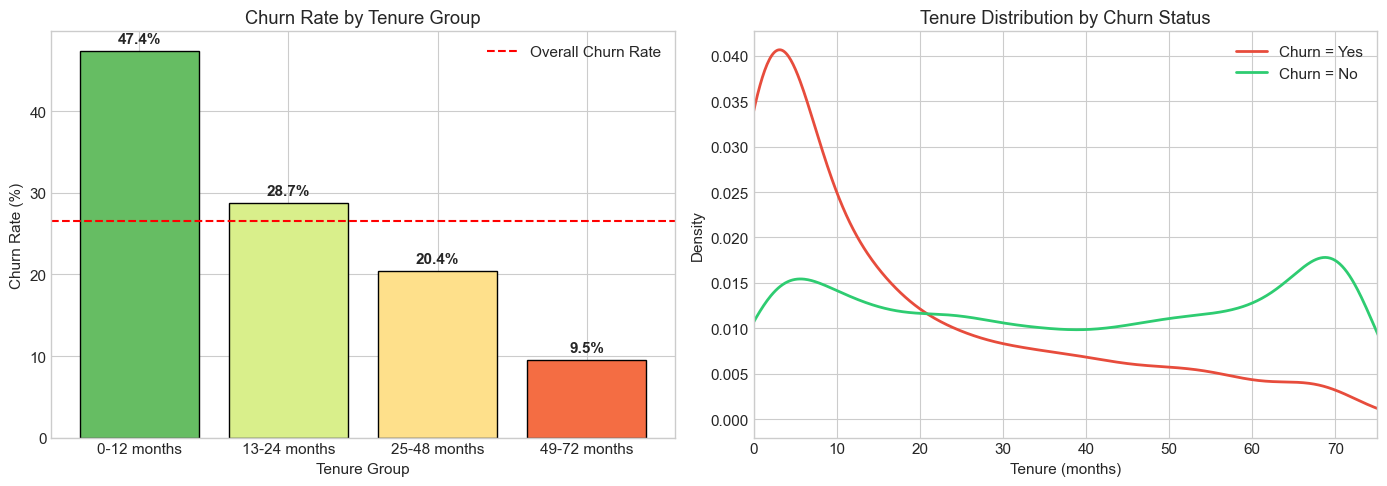

In [13]:
# Visualize churn rate by tenure group
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of churn rate
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(tenure_churn)))
axes[0].bar(tenure_churn["Tenure Group"], tenure_churn["Churn Rate (%)"], color=colors, edgecolor="black")
axes[0].set_xlabel("Tenure Group")
axes[0].set_ylabel("Churn Rate (%)")
axes[0].set_title("Churn Rate by Tenure Group")
axes[0].axhline(df[target].map({"Yes": 1, "No": 0}).mean() * 100, 
                color="red", linestyle="--", label="Overall Churn Rate")
axes[0].legend()

# Add values on bars
for i, (_, row) in enumerate(tenure_churn.iterrows()):
    axes[0].text(i, row["Churn Rate (%)"] + 1, f"{row['Churn Rate (%)']:.1f}%", ha="center", fontweight="bold")

# KDE plot by churn status
for churn_status, color in [("Yes", "#e74c3c"), ("No", "#2ecc71")]:
    subset = df[df[target] == churn_status]["tenure"]
    subset.plot.kde(ax=axes[1], label=f"Churn = {churn_status}", color=color, linewidth=2)

axes[1].set_xlabel("Tenure (months)")
axes[1].set_ylabel("Density")
axes[1].set_title("Tenure Distribution by Churn Status")
axes[1].legend()
axes[1].set_xlim(0, 75)

plt.tight_layout()
plt.show()

# Clean up temporary column
df.drop("tenure_group", axis=1, inplace=True)

### Numerical Features — Key Findings

| Feature | Finding | Implication |
|---------|---------|-------------|
| **tenure** | Churners have ~50% lower tenure | Early lifecycle = highest risk |
| **MonthlyCharges** | Churners pay ~$15 more/month | Price sensitivity signal |
| **TotalCharges** | Churners have lower total | Correlated with tenure |

---
## 4. Correlation Analysis

In [14]:
# Create a numeric version of target for correlation
df["Churn_encoded"] = df[target].map({"Yes": 1, "No": 0})

# Correlation matrix
corr_features = numerical_features + ["Churn_encoded"]
corr_matrix = df[corr_features].corr()

# Display correlation with target
print("Correlation with Churn:")
print("=" * 30)
target_corr = corr_matrix["Churn_encoded"].drop("Churn_encoded").sort_values(key=abs, ascending=False)
for feat, corr in target_corr.items():
    print(f"{feat}: {corr:+.3f}")

Correlation with Churn:
tenure: -0.352
TotalCharges: -0.199
MonthlyCharges: +0.193


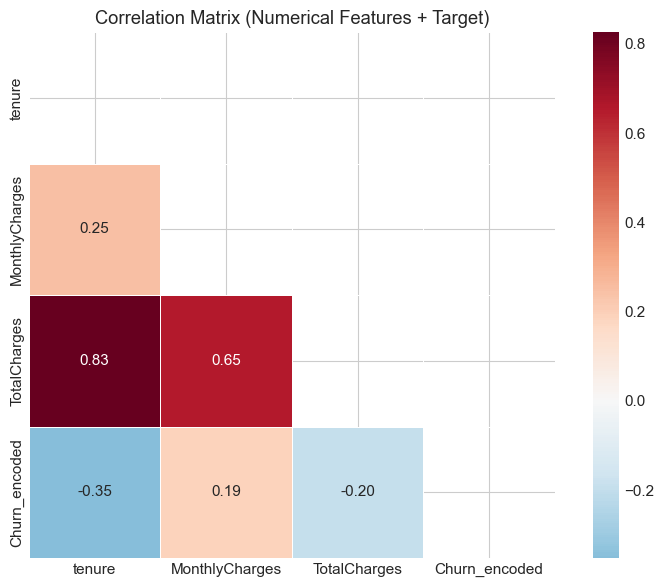

In [15]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap="RdBu_r", center=0, 
            mask=mask, fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Matrix (Numerical Features + Target)")
plt.tight_layout()
plt.show()

In [16]:
# Check multicollinearity: tenure vs TotalCharges
tenure_total_corr = df["tenure"].corr(df["TotalCharges"])
print(f"Correlation between tenure and TotalCharges: {tenure_total_corr:.3f}")

if abs(tenure_total_corr) > 0.7:
    print("\n⚠️ HIGH CORRELATION DETECTED")
    print("Consider dropping TotalCharges or creating interaction features.")

Correlation between tenure and TotalCharges: 0.826

⚠️ HIGH CORRELATION DETECTED
Consider dropping TotalCharges or creating interaction features.


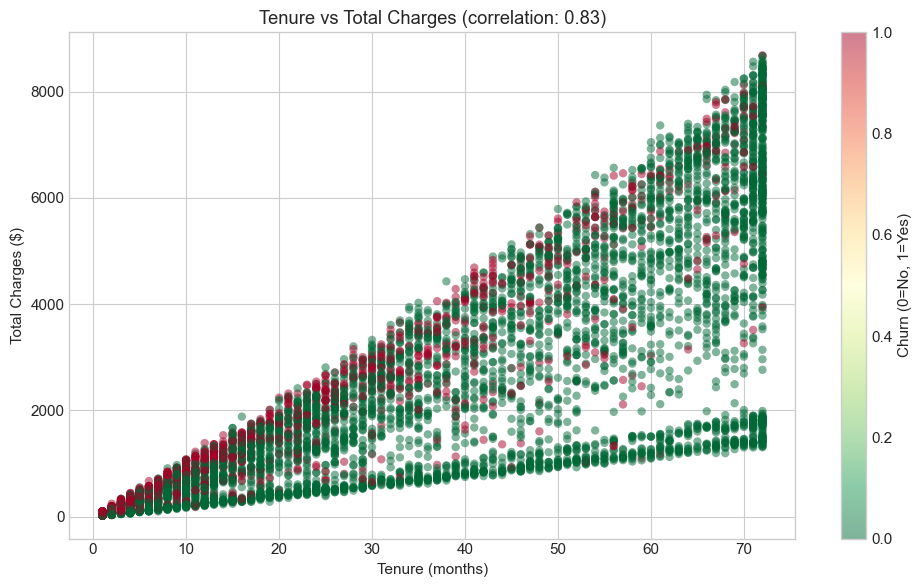

In [17]:
# Scatter plot: tenure vs TotalCharges
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df["tenure"], df["TotalCharges"], 
                      c=df["Churn_encoded"], cmap="RdYlGn_r", 
                      alpha=0.5, edgecolors="none")
plt.colorbar(scatter, label="Churn (0=No, 1=Yes)")
plt.xlabel("Tenure (months)")
plt.ylabel("Total Charges ($)")
plt.title(f"Tenure vs Total Charges (correlation: {tenure_total_corr:.2f})")
plt.tight_layout()
plt.show()

# Clean up
df.drop("Churn_encoded", axis=1, inplace=True)

### Correlation Analysis — Key Findings

1. **tenure** has the strongest negative correlation with churn (-0.35)
2. **MonthlyCharges** has a moderate positive correlation with churn (+0.19)
3. **TotalCharges** is highly correlated with tenure (0.83) — **potential multicollinearity**

**Recommendation:** Consider dropping `TotalCharges` or monitoring VIF during modeling.

---
## 5. Categorical Features Analysis

In [52]:
# Function to calculate churn rate by category
def churn_rate_by_category(df, column, target="Churn"):
    """Calculate churn rate for each category of a feature."""
    result = df.groupby(column)[target].agg([
        ("Count", "count"),
        ("Churn_Count", lambda x: (x == "Yes").sum()),
        ("Churn_Rate", lambda x: (x == "Yes").mean() * 100)
    ]).round(2)
    return result.sort_values("Churn_Rate", ascending=False)

In [19]:
# Chi-square tests for all categorical features
print("Chi-Square Tests (Categorical Features vs Churn):")
print("=" * 60)

chi2_results = []
for col in categorical_features:
    contingency = pd.crosstab(df[col], df[target])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    # Cramér's V for effect size
    n = contingency.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    chi2_results.append({
        "Feature": col,
        "Chi2": chi2,
        "p-value": p_value,
        "Cramér's V": cramers_v,
        "Significance": significance
    })

chi2_df = pd.DataFrame(chi2_results).sort_values("Cramér's V", ascending=False)
chi2_df

Chi-Square Tests (Categorical Features vs Churn):


,Feature,Chi2,p-value,Cramér's V,Significance
13,Contract,1184.60,0.00,0.41,***
7,OnlineSecurity,850.00,0.00,0.35,***
10,TechSupport,828.20,0.00,0.34,***
6,InternetService,732.31,0.00,0.32,***
15,PaymentMethod,648.14,0.00,0.30,***
8,OnlineBackup,601.81,0.00,0.29,***
9,DeviceProtection,558.42,0.00,0.28,***
12,StreamingMovies,375.66,0.00,0.23,***
11,StreamingTV,374.20,0.00,0.23,***
14,PaperlessBilling,258.28,0.00,0.19,***


### 5.1 Contract Type (Strongest Categorical Predictor)

In [20]:
# Contract analysis
print("Churn Rate by Contract Type:")
churn_rate_by_category(df, "Contract")

Churn Rate by Contract Type:


,Count,Churn_Count,Churn_Rate
Contract,,,
Month-to-month,3875,1655,42.71
One year,1473,166,11.27
Two year,1695,48,2.83


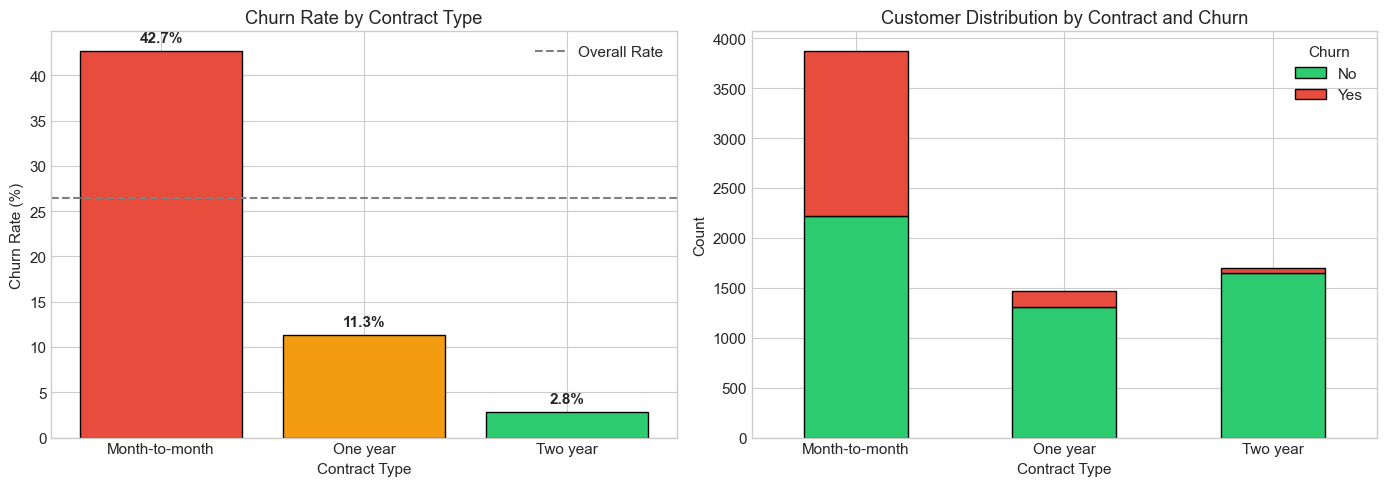

In [21]:
# Visualize Contract vs Churn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Churn rate by contract
contract_churn = df.groupby("Contract")[target].apply(lambda x: (x == "Yes").mean() * 100)
contract_order = ["Month-to-month", "One year", "Two year"]
colors = ["#e74c3c", "#f39c12", "#2ecc71"]

axes[0].bar(contract_order, [contract_churn[c] for c in contract_order], color=colors, edgecolor="black")
axes[0].set_xlabel("Contract Type")
axes[0].set_ylabel("Churn Rate (%)")
axes[0].set_title("Churn Rate by Contract Type")
axes[0].axhline(26.5, color="gray", linestyle="--", label="Overall Rate")
axes[0].legend()

for i, c in enumerate(contract_order):
    axes[0].text(i, contract_churn[c] + 1, f"{contract_churn[c]:.1f}%", ha="center", fontweight="bold")

# Stacked bar chart
contract_counts = pd.crosstab(df["Contract"], df[target])
contract_counts = contract_counts.loc[contract_order]
contract_counts.plot(kind="bar", stacked=True, ax=axes[1], color=["#2ecc71", "#e74c3c"], edgecolor="black")
axes[1].set_xlabel("Contract Type")
axes[1].set_ylabel("Count")
axes[1].set_title("Customer Distribution by Contract and Churn")
axes[1].legend(title="Churn")
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### 5.2 Internet Service Type

In [22]:
# Internet Service analysis
print("Churn Rate by Internet Service:")
churn_rate_by_category(df, "InternetService")

Churn Rate by Internet Service:


,Count,Churn_Count,Churn_Rate
InternetService,,,
Fiber optic,3096,1297,41.89
DSL,2421,459,18.96
No,1526,113,7.40


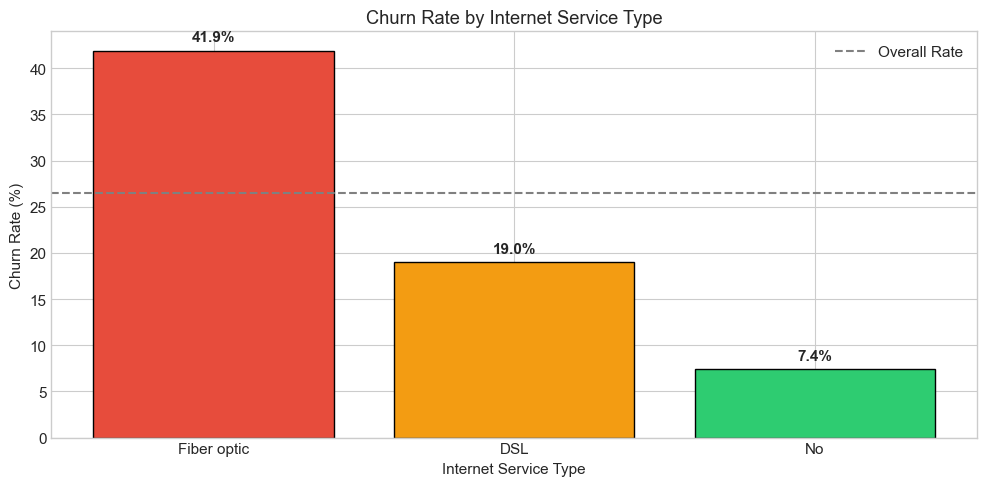

In [23]:
# Visualize Internet Service vs Churn
fig, ax = plt.subplots(figsize=(10, 5))

internet_churn = df.groupby("InternetService")[target].apply(lambda x: (x == "Yes").mean() * 100)
internet_order = ["Fiber optic", "DSL", "No"]
colors = ["#e74c3c", "#f39c12", "#2ecc71"]

ax.bar(internet_order, [internet_churn[i] for i in internet_order], color=colors, edgecolor="black")
ax.set_xlabel("Internet Service Type")
ax.set_ylabel("Churn Rate (%)")
ax.set_title("Churn Rate by Internet Service Type")
ax.axhline(26.5, color="gray", linestyle="--", label="Overall Rate")
ax.legend()

for i, itype in enumerate(internet_order):
    ax.text(i, internet_churn[itype] + 1, f"{internet_churn[itype]:.1f}%", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

### 5.3 Support Services (TechSupport, OnlineSecurity)

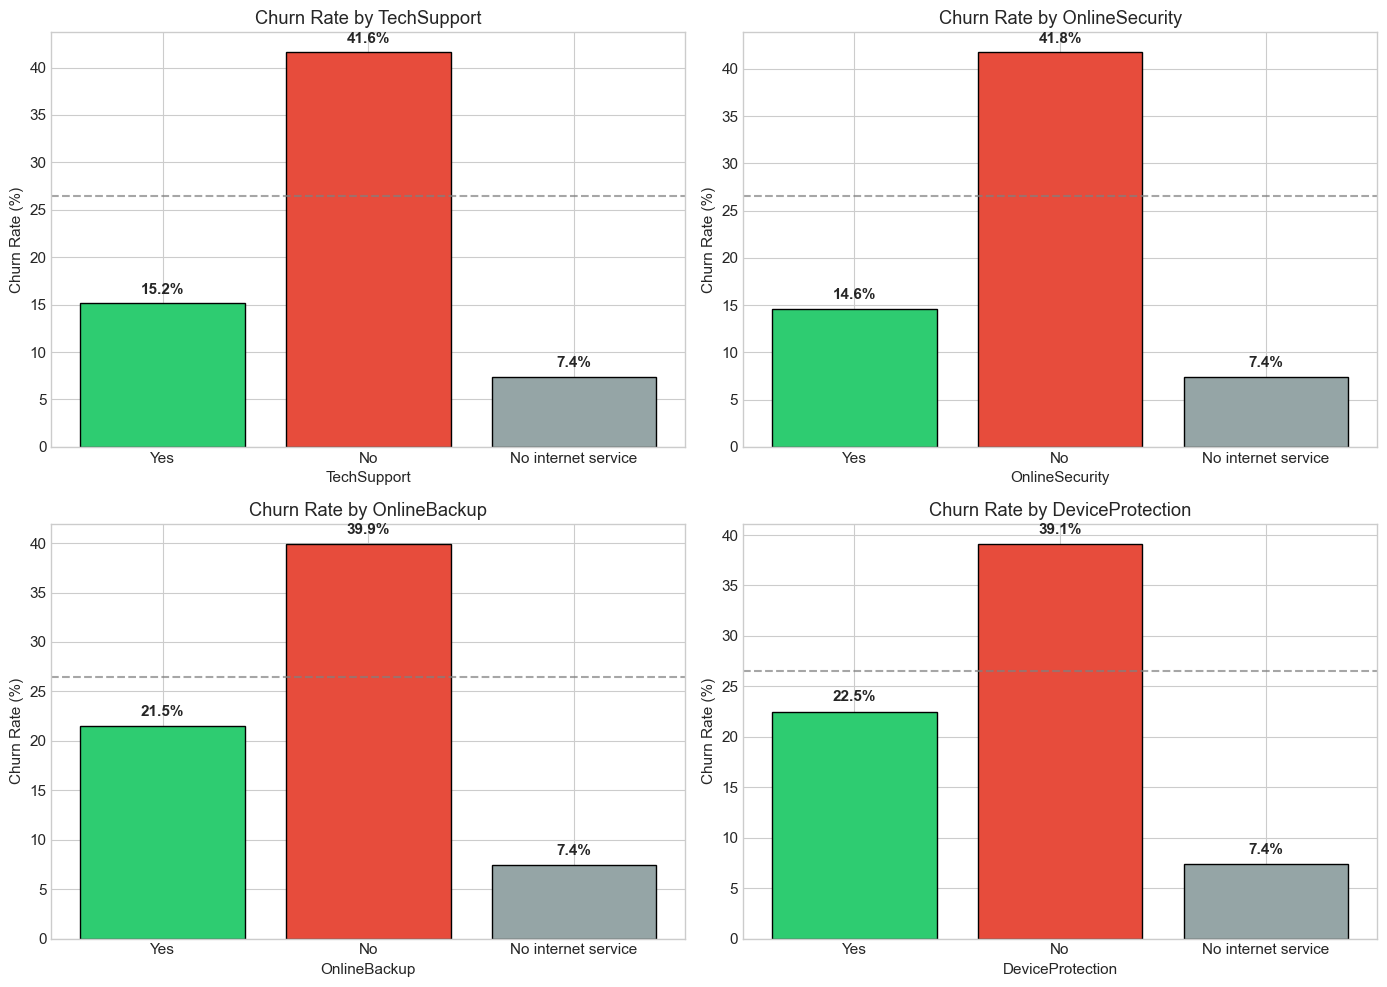

In [24]:
# Support services analysis
support_features = ["TechSupport", "OnlineSecurity", "OnlineBackup", "DeviceProtection"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(support_features):
    churn_rates = df.groupby(col)[target].apply(lambda x: (x == "Yes").mean() * 100)
    
    # Order: Yes, No, No internet service
    order = ["Yes", "No", "No internet service"] if "No internet service" in churn_rates.index else ["Yes", "No"]
    colors = ["#2ecc71", "#e74c3c", "#95a5a6"][:len(order)]
    
    bars = axes[i].bar(order, [churn_rates[o] for o in order], color=colors, edgecolor="black")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Churn Rate (%)")
    axes[i].set_title(f"Churn Rate by {col}")
    axes[i].axhline(26.5, color="gray", linestyle="--", alpha=0.7)
    
    for j, o in enumerate(order):
        axes[i].text(j, churn_rates[o] + 1, f"{churn_rates[o]:.1f}%", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

### 5.4 Payment Method

In [25]:
# Payment Method analysis
print("Churn Rate by Payment Method:")
churn_rate_by_category(df, "PaymentMethod")

Churn Rate by Payment Method:


,Count,Churn_Count,Churn_Rate
PaymentMethod,,,
Electronic check,2365,1071,45.29
Mailed check,1612,308,19.11
Bank transfer (automatic),1544,258,16.71
Credit card (automatic),1522,232,15.24


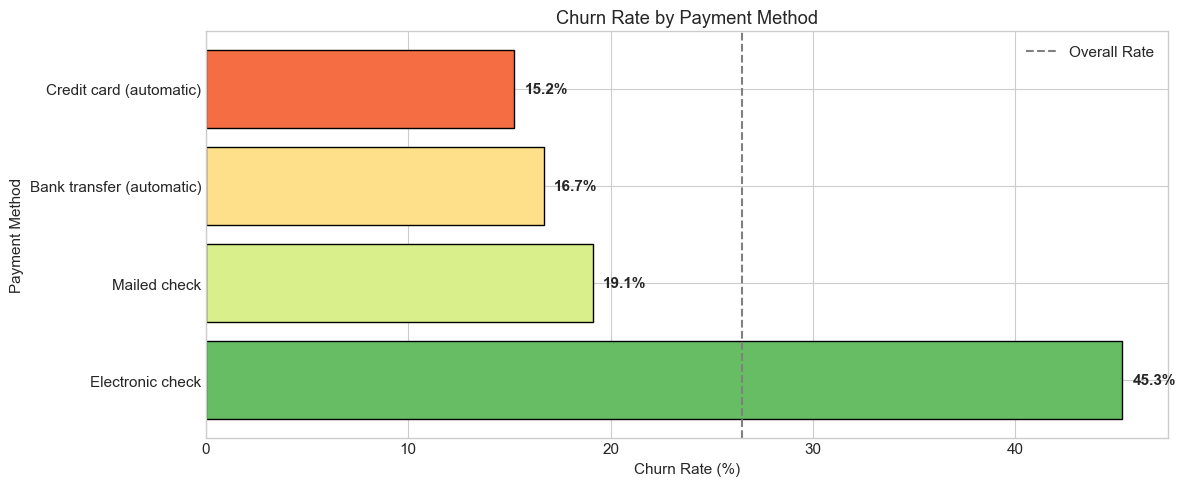

In [26]:
# Visualize Payment Method vs Churn
fig, ax = plt.subplots(figsize=(12, 5))

payment_churn = df.groupby("PaymentMethod")[target].apply(lambda x: (x == "Yes").mean() * 100)
payment_churn = payment_churn.sort_values(ascending=False)

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(payment_churn)))
ax.barh(payment_churn.index, payment_churn.values, color=colors, edgecolor="black")
ax.set_xlabel("Churn Rate (%)")
ax.set_ylabel("Payment Method")
ax.set_title("Churn Rate by Payment Method")
ax.axvline(26.5, color="gray", linestyle="--", label="Overall Rate")
ax.legend()

for i, (idx, val) in enumerate(payment_churn.items()):
    ax.text(val + 0.5, i, f"{val:.1f}%", va="center", fontweight="bold")

plt.tight_layout()
plt.show()

### 5.5 Demographic Features

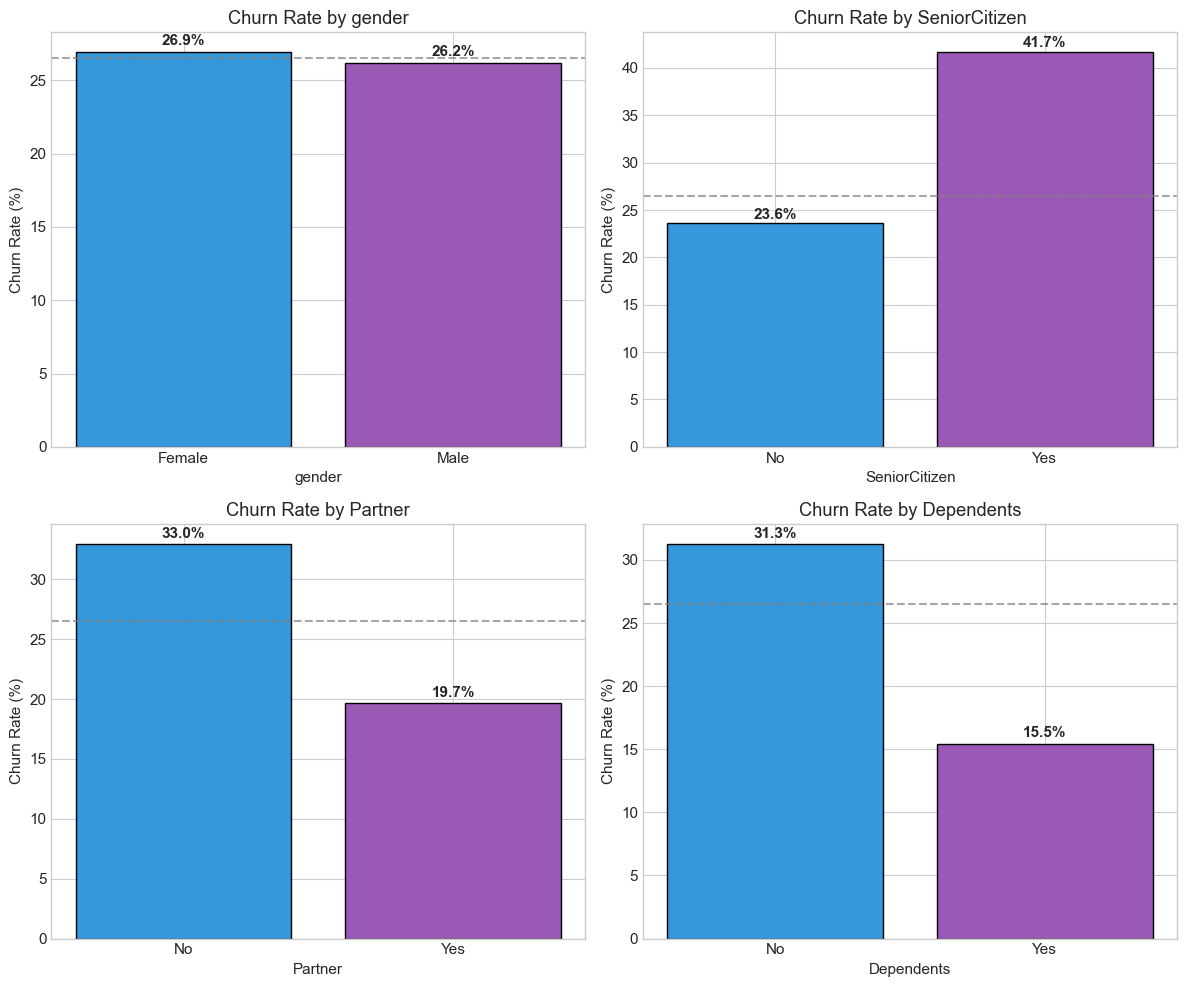

In [27]:
# Demographic features
demographic_features = ["gender", "SeniorCitizen", "Partner", "Dependents"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(demographic_features):
    if col == "SeniorCitizen":
        df["SeniorCitizen_str"] = df[col].map({0: "No", 1: "Yes"})
        churn_rates = df.groupby("SeniorCitizen_str")[target].apply(lambda x: (x == "Yes").mean() * 100)
        df.drop("SeniorCitizen_str", axis=1, inplace=True)
    else:
        churn_rates = df.groupby(col)[target].apply(lambda x: (x == "Yes").mean() * 100)
    
    colors = ["#3498db", "#9b59b6"] if len(churn_rates) == 2 else ["#3498db"]
    bars = axes[i].bar(churn_rates.index, churn_rates.values, color=colors, edgecolor="black")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Churn Rate (%)")
    axes[i].set_title(f"Churn Rate by {col}")
    axes[i].axhline(26.5, color="gray", linestyle="--", alpha=0.7)
    
    for j, (idx, val) in enumerate(churn_rates.items()):
        axes[i].text(j, val + 0.5, f"{val:.1f}%", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

### Categorical Features — Summary Table

In [28]:
# Summary of categorical features importance
cat_summary = chi2_df[["Feature", "Cramér's V", "Significance"]].copy()
cat_summary["Importance"] = pd.cut(
    cat_summary["Cramér's V"],
    bins=[0, 0.1, 0.2, 0.3, 1],
    labels=["Low", "Medium", "High", "Very High"]
)
cat_summary

,Feature,Cramér's V,Significance,Importance
13,Contract,0.41,***,Very High
7,OnlineSecurity,0.35,***,Very High
10,TechSupport,0.34,***,Very High
6,InternetService,0.32,***,Very High
15,PaymentMethod,0.30,***,Very High
8,OnlineBackup,0.29,***,High
9,DeviceProtection,0.28,***,High
12,StreamingMovies,0.23,***,High
11,StreamingTV,0.23,***,High
14,PaperlessBilling,0.19,***,Medium


---
## 6. Feature Importance Summary

In [29]:
# Create a comprehensive feature importance summary
feature_summary = pd.DataFrame({
    "Feature": [
        "Contract", "tenure", "OnlineSecurity", "TechSupport",
        "InternetService", "PaymentMethod", "OnlineBackup",
        "DeviceProtection", "MonthlyCharges", "SeniorCitizen",
        "PaperlessBilling", "Dependents", "Partner",
        "TotalCharges", "gender", "PhoneService"
    ],
    "Type": [
        "Categorical", "Numerical", "Categorical", "Categorical",
        "Categorical", "Categorical", "Categorical",
        "Categorical", "Numerical", "Categorical",
        "Categorical", "Categorical", "Categorical",
        "Numerical", "Categorical", "Categorical"
    ],
    "Importance": [
        "Very High", "Very High", "High", "High",
        "High", "High", "Medium",
        "Medium", "Medium", "Medium",
        "Medium", "Low", "Low",
        "Low (redundant)", "None", "None"
    ],
    "Key Finding": [
        "Month-to-month = 42% churn vs Two-year = 3%",
        "Churners have 50% lower tenure",
        "No security = 42% churn vs Yes = 15%",
        "No support = 42% churn vs Yes = 15%",
        "Fiber optic = 42% churn vs DSL = 19%",
        "Electronic check = 45% churn vs Auto = 15-18%",
        "No backup = 40% churn vs Yes = 22%",
        "No protection = 39% churn vs Yes = 23%",
        "Churners pay ~$15 more/month",
        "Seniors = 41% churn vs Non-seniors = 24%",
        "Paperless = 34% churn vs Paper = 16%",
        "No dependents slightly higher churn",
        "No partner slightly higher churn",
        "Highly correlated with tenure (0.83)",
        "No significant difference",
        "No significant difference"
    ]
})

feature_summary

,Feature,Type,Importance,Key Finding
0,Contract,Categorical,Very High,Month-to-month = 42% churn vs Two-year = 3%
1,tenure,Numerical,Very High,Churners have 50% lower tenure
2,OnlineSecurity,Categorical,High,No security = 42% churn vs Yes = 15%
3,TechSupport,Categorical,High,No support = 42% churn vs Yes = 15%
4,InternetService,Categorical,High,Fiber optic = 42% churn vs DSL = 19%
5,PaymentMethod,Categorical,High,Electronic check = 45% churn vs Auto = 15-18%
6,OnlineBackup,Categorical,Medium,No backup = 40% churn vs Yes = 22%
7,DeviceProtection,Categorical,Medium,No protection = 39% churn vs Yes = 23%
8,MonthlyCharges,Numerical,Medium,Churners pay ~$15 more/month
9,SeniorCitizen,Categorical,Medium,Seniors = 41% churn vs Non-seniors = 24%


---
## 7. EDA Conclusion

### Key Findings

#### Target Variable
- Churn rate: **26.5%** (moderately imbalanced)
- Requires recall-focused evaluation metrics

#### Top Churn Predictors

| Rank | Feature | Finding |
|------|---------|--------|
| 1 | **Contract** | Month-to-month customers churn 14x more than Two-year |
| 2 | **tenure** | First 12 months = highest risk period (47% churn) |
| 3 | **OnlineSecurity/TechSupport** | Support services reduce churn by ~60% |
| 4 | **InternetService** | Fiber optic = highest churn (42%) |
| 5 | **PaymentMethod** | Electronic check = 45% churn |

#### Multicollinearity Alert
- `tenure` and `TotalCharges` correlation: **0.83**
- Recommendation: Consider dropping `TotalCharges` or monitoring VIF

#### Features with No Predictive Power
- `gender`: No significant difference in churn rates
- `PhoneService`: Minimal impact on churn

### Business Insights

1. **Early Intervention is Critical**: Focus retention efforts on customers in first 12 months
2. **Contract Strategy**: Incentivize longer contracts (significant churn reduction)
3. **Service Bundling**: Promote security and support add-ons
4. **Payment Friction**: Encourage automatic payment methods
5. **Fiber Optic Attention**: Investigate quality/pricing issues for fiber customers

### Modeling Recommendations

1. **Primary metric**: Recall (target ≥ 80%)
2. **Secondary metric**: ROC-AUC (target ≥ 0.85)
3. **Use class_weight='balanced'** to handle imbalance
4. **Consider dropping** `TotalCharges` due to multicollinearity
5. **Drop** `customerID` (identifier, not a feature)
6. **Keep** `gender` and `PhoneService` for completeness (model can learn to ignore)

### Next Steps

Proceed to **Notebook 05 — Preprocessing** to prepare the data for modeling.